In [1]:
#' The results could be a little bit different from the results shown in the manuscript,
#' but they should be consistent in general.

In [2]:
# BiocManager::install(c("caret", "doParallel", "pROC", "PRROC", "ggplot2", "randomForest"))
# devtools::install_github('liulab-dfci/MAPD')

In [3]:
suppressMessages(library(caret))
suppressMessages(library(ggplot2))
suppressMessages(library(randomForest))
suppressMessages(library(pROC))
suppressMessages(library(PRROC))
suppressMessages(library(doParallel))
suppressMessages(library(MAPD))
options(stringsAsFactors = FALSE)
source("src/cvAUC.R")

In [4]:
trainDat = read.table("data/Training_data.txt", sep = "\t")

## Train model and tune parameters
features = list()
features$rf = c("Ubiquitination_2", "Zecha2018_Hela_Halflife", "Length", "Acetylation_1", "Phosphorylation_2")
features$svml = c("Ubiquitination_2", "Mathieson2018_NKs_Halflife", "MLN4924_DMSO.PSI", "Phosphorylation_2")
features$svmr = c("Ubiquitination_2", "Phosphorylation_2", "Mathieson2018_Hepatocytes_Halflife")
features$knn = c("Ubiquitination_2", "Phosphorylation_2", "Zecha2018_Hela_Halflife", "Methylation.K_1", "Sumoylation_1")
features$glm = c("Ubiquitination_2", "MLN4924_DMSO.PSI", "Mathieson2018_NKs_Halflife", "Phosphorylation_2", "MOLT4_RNA")
features$nb = c("Ubiquitination_2", "Zecha2018_Hela_Halflife", "Mathieson2018_NKs_Halflife", "Acetylation_1", "Nterminome")

fitControl <- trainControl(method = "LOOCV", summaryFunction = prSummary)
models = list()
cl <- makePSOCKcluster(2)
registerDoParallel(cl)
#### svm will use more memory (more core will lead to training-out-of-memory) 
message(Sys.time(), " Train the SVM linear ...")
models$svm_linear <- train(x=trainDat[, features$svml], y=trainDat$Degradability, metric = "F",
                           method = "svmLinear", trControl = fitControl, tuneLength = 20)
message(Sys.time(), " Train the SVM Radial ...")
models$svm_radial <- train(x=trainDat[, features$svmr], y=trainDat$Degradability, metric = "F",
                           method = "svmRadial", trControl = fitControl, tuneLength = 20)

cl <- makePSOCKcluster(20)
registerDoParallel(cl)
#### random forest will take more time (more core is recommended) 
message(Sys.time(), " Train the random forest model ...")
models$rf <- train(x=trainDat[, features$rf], y=trainDat$Degradability, method = "rf", metric = "F",
                   ntree = 10000, nodesize = 5, trControl = fitControl, tuneLength = 5)
message(Sys.time(), " Train the logistic regression model ...")
models$logistic <- train(x=trainDat[, features$glm], y=trainDat$Degradability, method = "glm", metric = "F",
                         family = "binomial", trControl = fitControl)
message(Sys.time(), " Train the KNN ...")
models$knn <- train(x=trainDat[, features$knn], y=trainDat$Degradability, method = "knn", metric = "F",
                    trControl = fitControl, tuneLength = 3)
message(Sys.time(), " Train the Naive Bayes ...")
models$naive_bayes <- train(x=trainDat[, features$nb], y=trainDat$Degradability, method = "naive_bayes",
                            metric = "F", trControl = fitControl, tuneLength = 10)

2021-09-22 23:41:50 Train the SVM linear ...

2021-09-22 23:41:54 Train the SVM Radial ...

Warning message in train.default(x = trainDat[, features$svmr], y = trainDat$Degradability, :
“missing values found in aggregated results”
2021-09-22 23:42:28 Train the random forest model ...



note: only 4 unique complexity parameters in default grid. Truncating the grid to 4 .



2021-09-22 23:42:56 Train the logistic regression model ...

2021-09-22 23:42:57 Train the KNN ...

2021-09-22 23:42:58 Train the Naive Bayes ...



In [5]:
# 20-fold cross validation
prList = list()
fold = 20
seed = 19
message(Sys.time(), " random forest model ...")
prList$RF = cvAUC(x=trainDat[, features$rf], y=trainDat$Degradability, models$rf$bestTune, method = "rf", 
                  ntree = 10000, nodesize = 5, fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " regLogistic model ...")
prList$Logistic = cvAUC(x=trainDat[, features$glm], y=trainDat$Degradability, models$logistic$bestTune, 
                        method = "glm", family = "binomial", fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " KNN model ...")
prList$KNN = cvAUC(x=trainDat[, features$knn], y=trainDat$Degradability, models$knn$bestTune, 
                   method = "knn", fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " naive_bayes model ...")
prList$NB = cvAUC(x=trainDat[, features$nb], y=trainDat$Degradability, models$naive_bayes$bestTune, method = "naive_bayes", 
                  fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " svmLinear model ...")
prList$svmLinear = cvAUC(x=trainDat[, features$svml], y=trainDat$Degradability, models$svm_linear$bestTune, method = "svmLinear", 
                   fold = fold, metric = "prROC", seed = seed)
message(Sys.time(), " svm_radial model ...")
prList$svmRadial = cvAUC(x=trainDat[, features$svmr], y=trainDat$Degradability, models$svm_radial$bestTune, method = "svmRadial", 
                   fold = fold, metric = "prROC", seed = seed)

2021-09-22 23:42:59 random forest model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:43:17 regLogistic model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:43:24 KNN model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:43:31 naive_bayes model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:43:38 svmLinear model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:43:45 svm_radial model ...

Setting levels: control = high, case = low

Setting direction: controls > cases



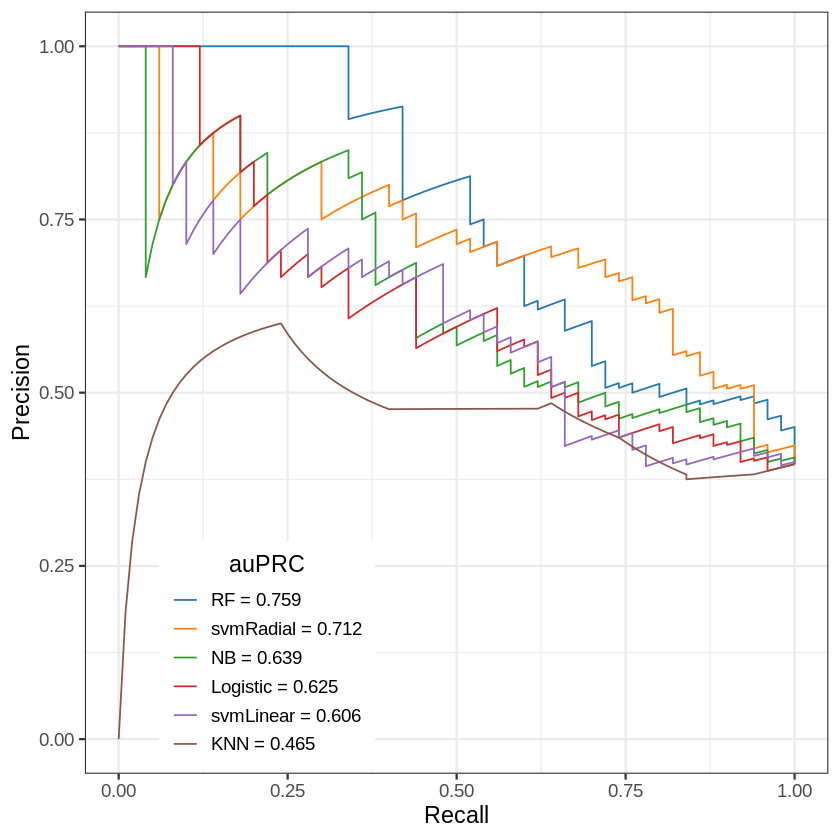

In [6]:
colors = c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2')
# prList = readRDS("data/PR_list.rds")
p = PRC.plot(prList)
p = p + scale_color_manual(values = colors)
p = p + theme(legend.position = c(0.1, 0.005))
p

In [7]:
rocList = list()
fold = 20
seed = 3
message(Sys.time(), " random forest model ...")
rocList$RF = cvAUC(x=trainDat[, features$rf], y=trainDat$Degradability, models$rf$bestTune, 
                   method = "rf", ntree = 20000, nodesize = 5, fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " regLogistic model ...")
rocList$Logistic = cvAUC(x=trainDat[, features$glm], y=trainDat$Degradability, models$logistic$bestTune, 
                         method = "glm", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " KNN model ...")
rocList$KNN = cvAUC(x=trainDat[, features$knn], y=trainDat$Degradability, models$knn$bestTune, 
                    method = "knn", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " naive_bayes model ...")
rocList$NB = cvAUC(x=trainDat[, features$nb], y=trainDat$Degradability, models$naive_bayes$bestTune, 
                   method = "naive_bayes", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " svmLinear model ...")
rocList$svmLinear = cvAUC(x=trainDat[, features$svml], y=trainDat$Degradability, models$svm_linear$bestTune, 
                          method = "svmLinear", fold = fold, metric = "auROC", seed = seed)
message(Sys.time(), " svm_radial model ...")
rocList$svmRadial = cvAUC(x=trainDat[, features$svmr], y=trainDat$Degradability, models$svm_radial$bestTune, 
                          method = "svmRadial", fold = fold, metric = "auROC", seed = seed)

2021-09-22 23:43:53 random forest model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:44:26 regLogistic model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:44:34 KNN model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:44:41 naive_bayes model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:44:48 svmLinear model ...

Setting levels: control = high, case = low

Setting direction: controls > cases

2021-09-22 23:44:55 svm_radial model ...

Setting levels: control = high, case = low

Setting direction: controls > cases



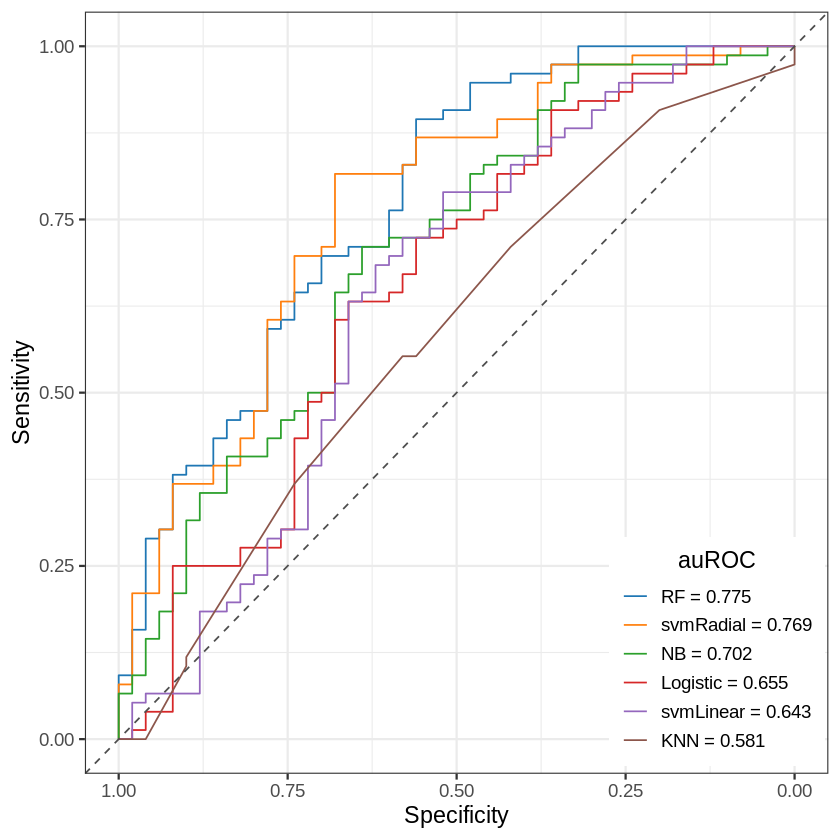

In [8]:
colors = c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2')
# rocList = readRDS("data/ROC_list.rds")
p = ROC.plot(rocList)
p = p + scale_color_manual(values = colors)
p = p + theme(legend.position = c(0.995, 0.01))
p

In [9]:
#### Compare model trained on individual features or the combination of PTM features

In [10]:
featureLists = list(Ubiquitination_2 = c("Ubiquitination_2"),
                    Phosphorylation_2 = "Phosphorylation_2",
                    Hela_Halflife = c("Zecha2018_Hela_Halflife"),
                    Length = c("Length"),
                    PTMs = c("Ubiquitination_2", "Acetylation_1", "Phosphorylation_2"))
cl <- makePSOCKcluster(20)
registerDoParallel(cl)
fitControl <- trainControl(method = "LOOCV")
prLists2 = lapply(featureLists, function(x){
    if(length(x)==1){
        tmpM <- train(x=trainDat[, x,drop=FALSE], y=trainDat$Degradability,
                      trControl = fitControl, method = "glm", family = "binomial")
        rocs = cvAUC(trainDat[, x,drop=FALSE], trainDat$Degradability, tmpM$bestTune, 
                     method = "glm", family = "binomial", metric = "prROC", fold = 20)
        rocs
    }else{
        tmpM <- train(x=trainDat[, x], y=trainDat$Degradability, method = "rf", ntree = 20000, nodesize = 5, 
                      trControl = fitControl, tuneLength = 2)
        rocs = cvAUC(trainDat[, x], trainDat$Degradability, tmpM$bestTune, method = "rf", 
                     ntree = 20000, nodesize = 5, metric = "prROC", fold = 20)
        rocs
    }
})

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases



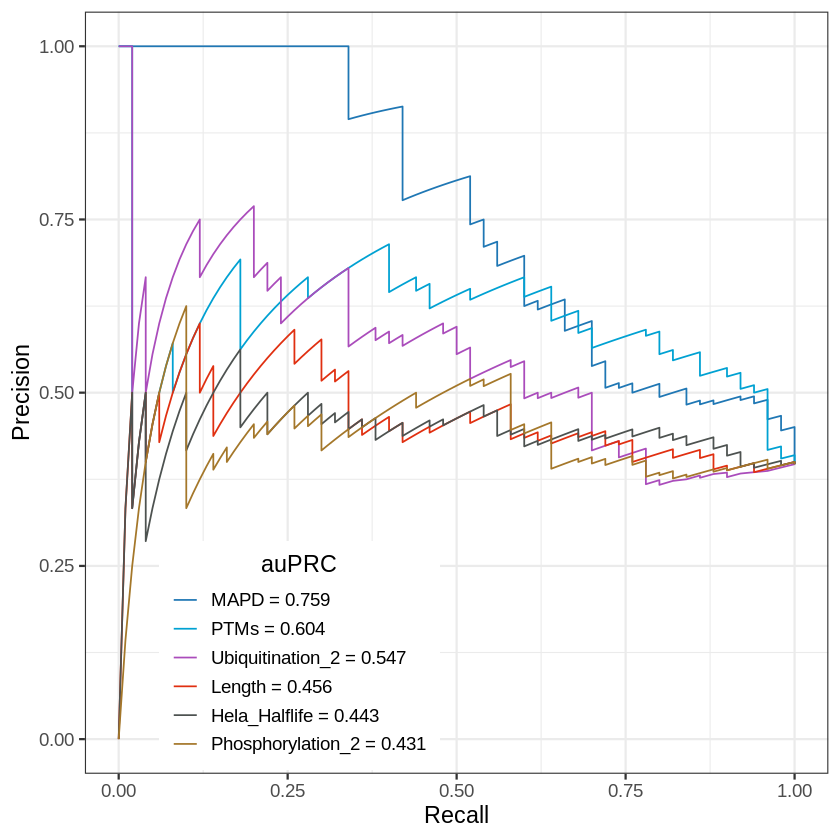

In [11]:
colors = c('#1f77b4', '#00a1d2', '#aa4cbb', '#e02f10', '#4d5250', '#a4772a', '#1b9e77', '#7570b3')[1:6]
prLists2 = c(MAPD = prList[1], prLists2)
names(prLists2) = c("MAPD", "Ubiquitination_2", "Phosphorylation_2", "Hela_Halflife", "Length", "PTMs")
p = PRC.plot(prLists2)
p = p + scale_color_manual(values = colors)
p = p + theme(legend.position = c(0.1, 0.005))
p

In [12]:
featureLists = list(Ubiquitination_2 = c("Ubiquitination_2"),
                    Phosphorylation_2 = "Phosphorylation_2",
                    Hela_Halflife = c("Zecha2018_Hela_Halflife"),
                    Length = c("Length"),
                    PTMs = c("Ubiquitination_2", "Acetylation_1", "Phosphorylation_2"))
fitControl <- trainControl(method = "LOOCV")
cl <- makePSOCKcluster(20)
registerDoParallel(cl)
rocLists2 = lapply(featureLists, function(x){
    if(length(x)==1){
        tmpM <- train(x=trainDat[, x,drop=FALSE], y=trainDat$Degradability, 
                      trControl = fitControl, method = "glm", family = "binomial")
        rocs = cvAUC(trainDat[, x,drop=FALSE], trainDat$Degradability, tmpM$bestTune, 
                     method = "glm", family = "binomial", metric = "auROC", fold = 20)
        return(rocs)
    }else{
        tmpM <- train(x=trainDat[, x], y=trainDat$Degradability, method = "rf", ntree = 20000, nodesize = 5,
                      trControl = fitControl, tuneLength = 2)
        rocs = cvAUC(trainDat[, x], trainDat$Degradability, tmpM$bestTune, method = "rf", 
                     ntree = 20000, nodesize = 5, metric = "auROC", fold = 20)
        return(rocs)
    }
})

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases

Setting levels: control = high, case = low

Setting direction: controls > cases



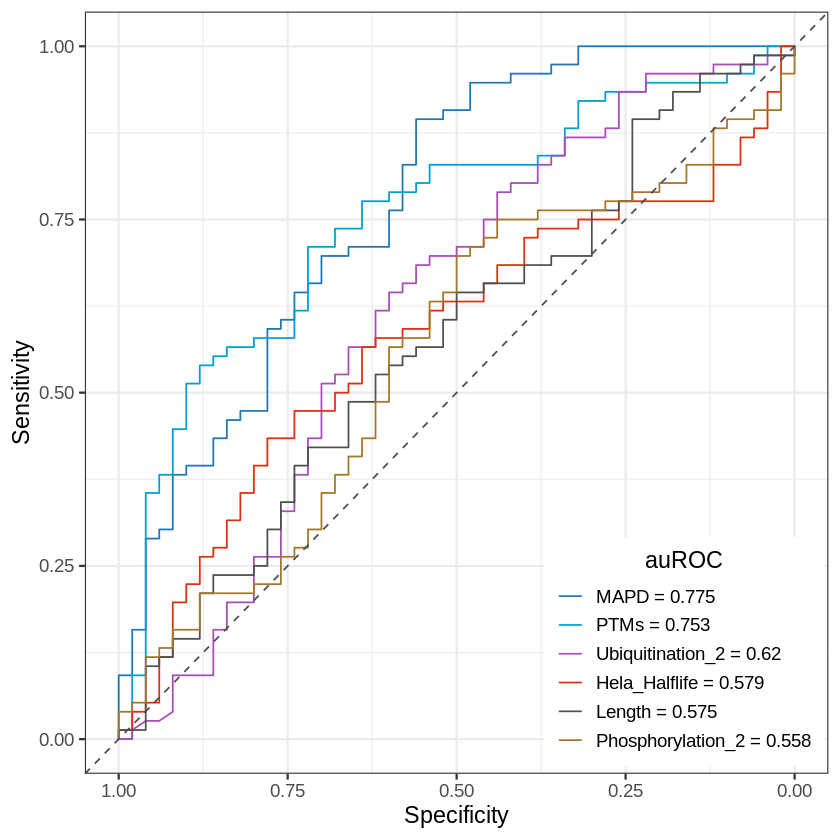

In [13]:
colors = c('#1f77b4', '#00a1d2', '#aa4cbb', '#e02f10', '#4d5250', '#a4772a', '#1b9e77', '#7570b3')[1:6]
rocLists2 = c(rocList[1], rocLists2)
names(rocLists2) = c("MAPD", "Ubiquitination_2", "Phosphorylation_2", "Hela_Halflife", "Length", "PTMs")
p = ROC.plot(rocLists2)
p = p + scale_color_manual(values = colors)
p = p + theme(legend.position = c(0.995, 0.01))
p

In [14]:
roc.test(rocLists2$PTMs, rocLists2$Ubiquitination_2, method="delong")
detect_roc = roc(trainDat$Degradability, trainDat$Detectability)
roc.test(rocList$RF, detect_roc, method="delong")


	DeLong's test for two ROC curves

data:  rocLists2$PTMs and rocLists2$Ubiquitination_2
D = 1.9022, df = 240.85, p-value = 0.05834
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7526316   0.6202632 


Setting levels: control = high, case = low

Setting direction: controls < cases

Warning message in roc.test.roc(rocList$RF, detect_roc, method = "delong"):
“DeLong's test should not be applied to ROC curves with a different direction.”



	DeLong's test for two ROC curves

data:  rocList$RF and detect_roc
D = 4.6376, df = 244.22, p-value = 5.746e-06
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7750000   0.4665789 
